# Santander Customer Transaction Prediction

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from  sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from scipy.special import logit

# Problem Definition

* Santander bank is the 16th largest banking institution in the world.
* They are always looking at ways to improve their customer experience, helping them understand their financial health and achieve their monetary goals with relevant products and services by using Artificial Intelligence.
* Here, the task is to identify which customer will make a specific transaction in the future irrespective of the amount of money they spend. So, it's a binary classification problem.
* This enables them to provide customized service and saves cost by targeted advertising.
* We should correctly predict if a customer makes a transaction, so TPR should be as high as possible.
* There are no low-latency requirements, there is no requirement for output to be predicted in milliseconds, but it should be able to predict within a few minutes.

# Data Preparation

**Data Source:** https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download santander-customer-transaction-prediction

 94% 234M/250M [00:01<00:00, 216MB/s]
100% 250M/250M [00:01<00:00, 196MB/s]


In [ ]:
!unzip /content/santander-customer-transaction-prediction.zip

Archive:  /content/santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
#import train and test data into pandas dataframe
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

Looking at the top and bottom rows


In [ ]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
train_data.tail()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


* There are **2,00,000** rows and **202** columns in the training data.
* The target column is binary, class 1 represents a customer who made a transaction, and class 0 represents a customer who didn't make a transaction.
* ID_code - uniquely identifies each row
* Rest 200 columns are numeric data, we don't have any knowledge about what these represent.
* There are both positive and negative values in these numeric columns.

In [ ]:
train_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 319.8 MB


* The 200 numeric features named var_0 to var_199 of **float64** data type.
*  The ID_Code column, which uniquely identifies each row, is of **int** data type and the target column is of **string** data type.
* The entire training data occupies roughly around **300MB** of space.

In [ ]:
#Separating the target column from the rest of the data.
x_train = train_data.drop('target',axis=1)
y_train = train_data.target.astype(int)

After separating the target column from the rest of the data. it's data type is converted to **int**.

## Checking for missing values and duplicate entries.

In [ ]:
if not any(x_train.isnull().sum()):
  print('There are no missing values in training data')
if not any(test_data.isnull().sum()):
  print('There are no missing values in test data')

There are no missing values in training data
There are no missing values in test data


In [ ]:
y_train.isnull().sum()

0

There are no missing values in the training and test data.

In [ ]:
count = 0
for i in x_train.duplicated():
    if i == True:
        count += 1
if count == 0:
  print('There are no duplicate rows in training data')

There are no duplicate rows in training data


In [ ]:
count = 0
for i in test_data.duplicated():
    if i == True:
        count += 1
if count == 0:
  print('There are no duplicate rows in test data')

There are no duplicate rows in test data


# Performance Metric

* Receiver Operating Characteristic (ROC) - is the graphical plot depicting the performance of the classification model at all classification thresholds, with two parameters - True Positive Rate & False Positive Rate.
* The area under this curve, also known as the "Area under ROC curve (AUC)" - is another metric that we will use in this case study to evaluate the performance of the model between the predicted probability and the observed target.

# Exploratory Data Analysis

## Descriptive Statistics

### Distribution of target variable

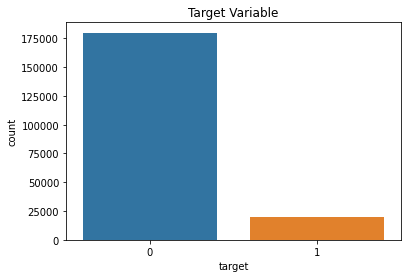

In [ ]:
plt.title('Target Variable')
sns.countplot(x="target", data=train_data)
plt.show()

In [ ]:
y_train.value_counts()

1    143909
0    143909
Name: target, dtype: int64

* The dataset is **highly imbalanced**.
* Around 20,000 data points belonging to class 1 and around 1,79,000 data points belonging to class 0. 
* Roughly, only around 10% of customers are likely to make a transaction. 

### Distribution of all features

In [ ]:
#Separating the dataframes according to their class labels
x_train_0 = train_data[train_data['target'] == 0]
x_train_1 = train_data[train_data['target'] == 1]

ref: https://stackoverflow.com/questions/50773877/create-for-loop-to-plot-histograms-for-individual-columns-of-dataframe-with-seab


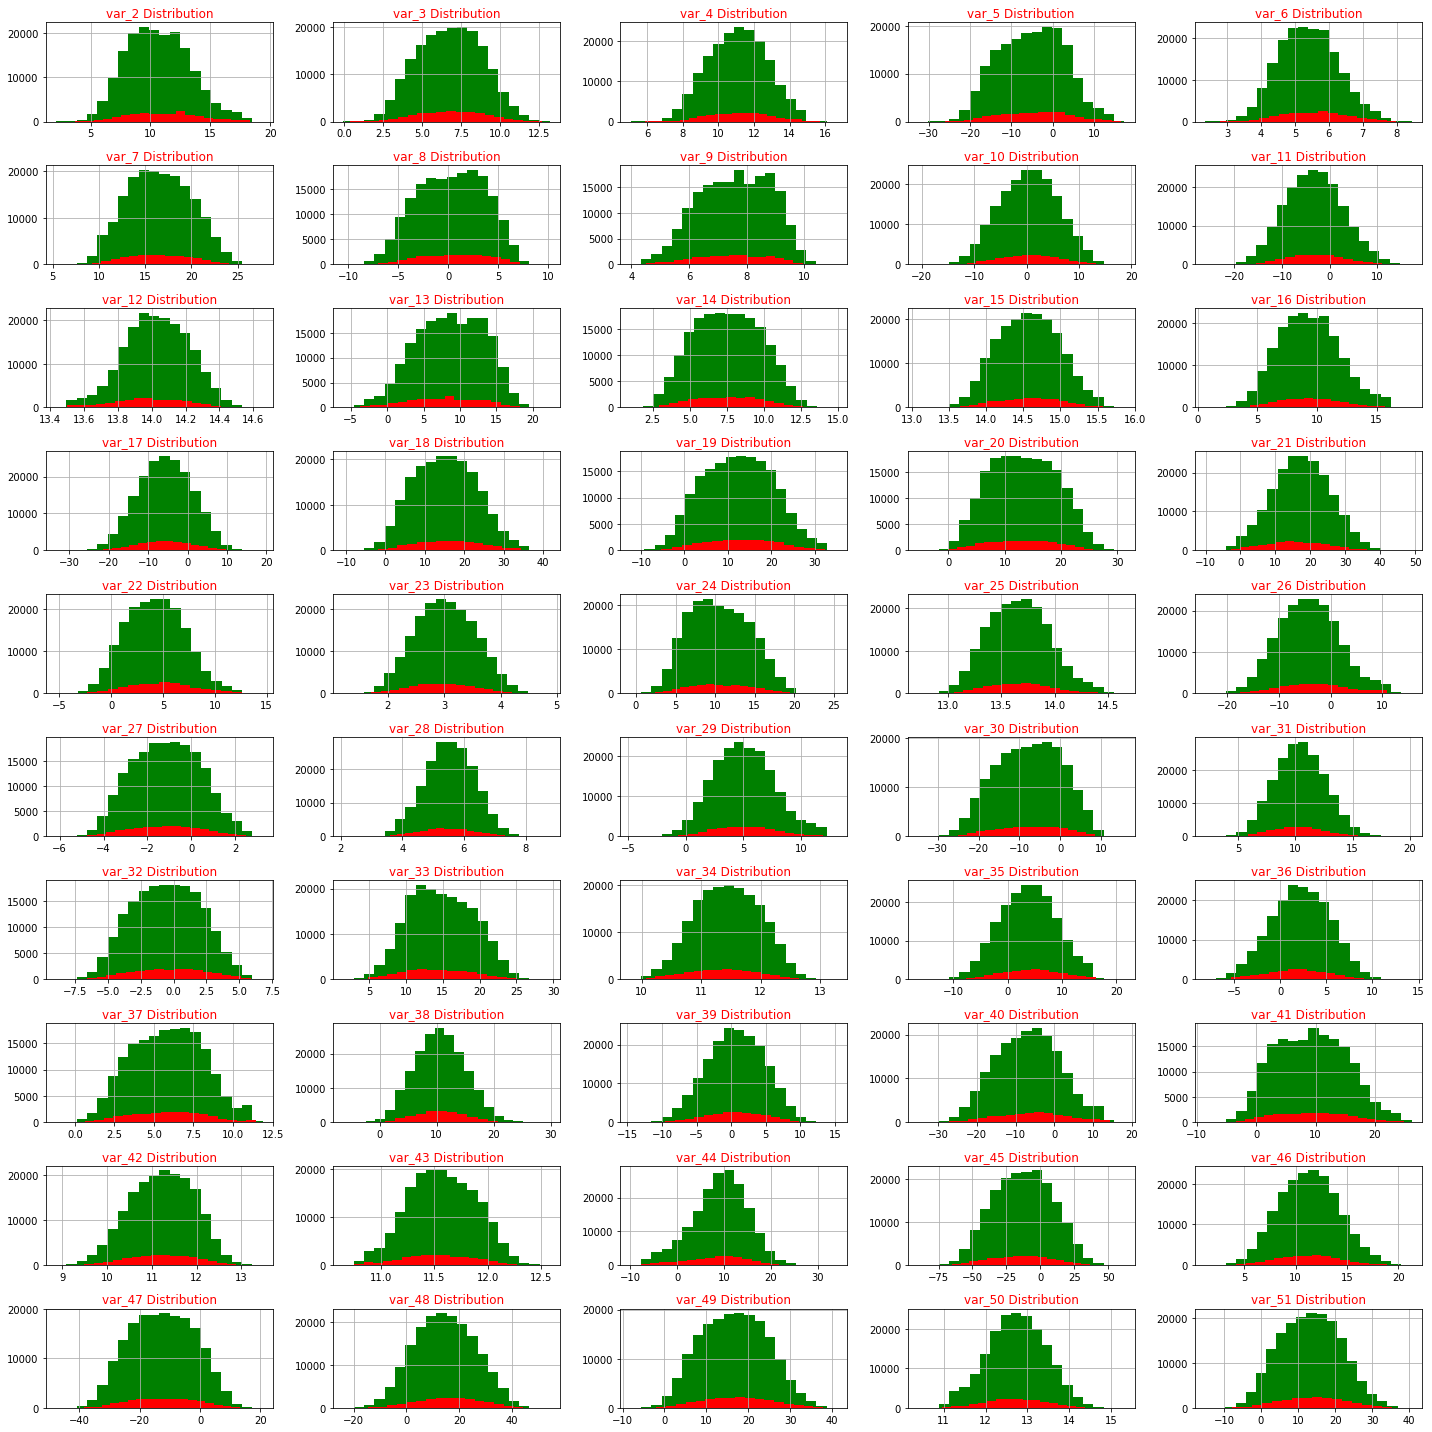

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[2:52])):
    ax=fig.add_subplot(10,5,i+1)
    x_train_0[feature].hist(bins=20,ax=ax,facecolor='green')
    x_train_1[feature].hist(bins=20,ax=ax,facecolor='red')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

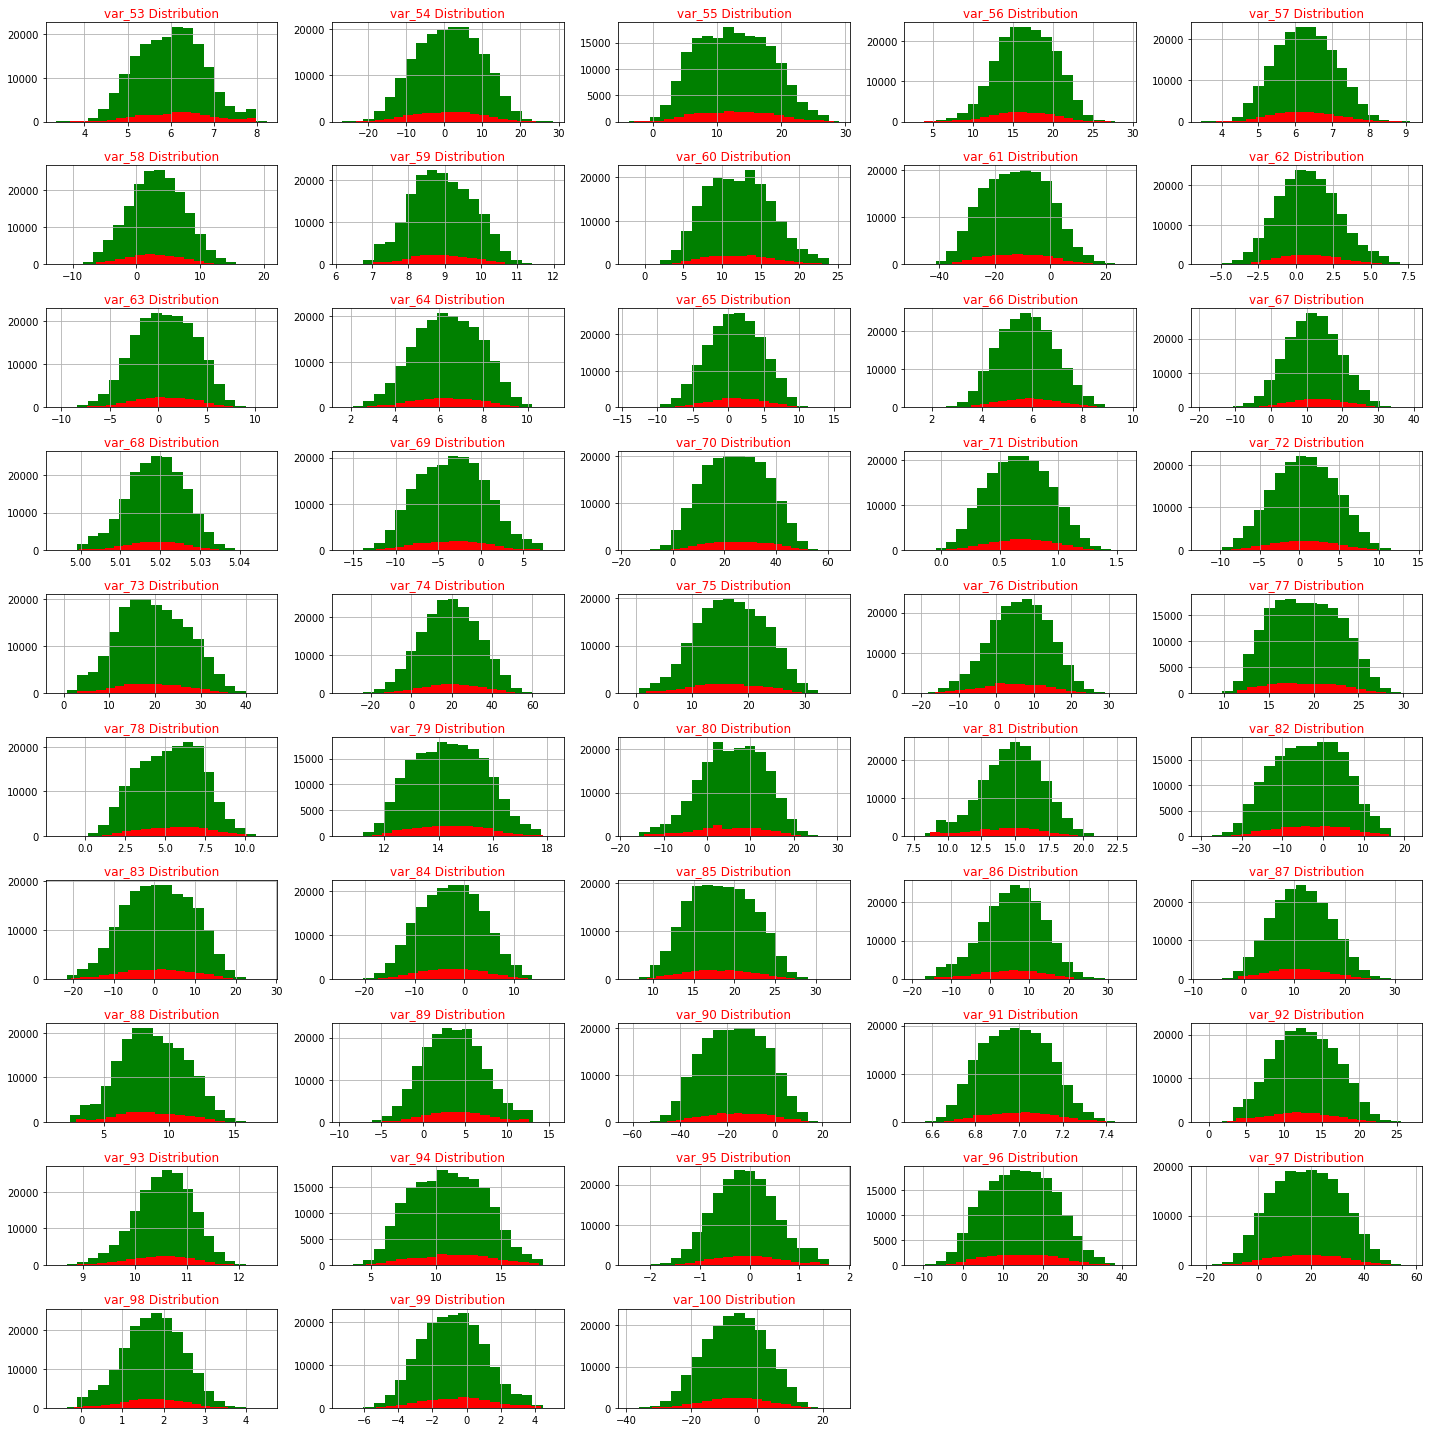

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[53:101])):
    ax=fig.add_subplot(10,5,i+1)
    x_train_0[feature].hist(bins=20,ax=ax,facecolor='green')
    x_train_1[feature].hist(bins=20,ax=ax,facecolor='red')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

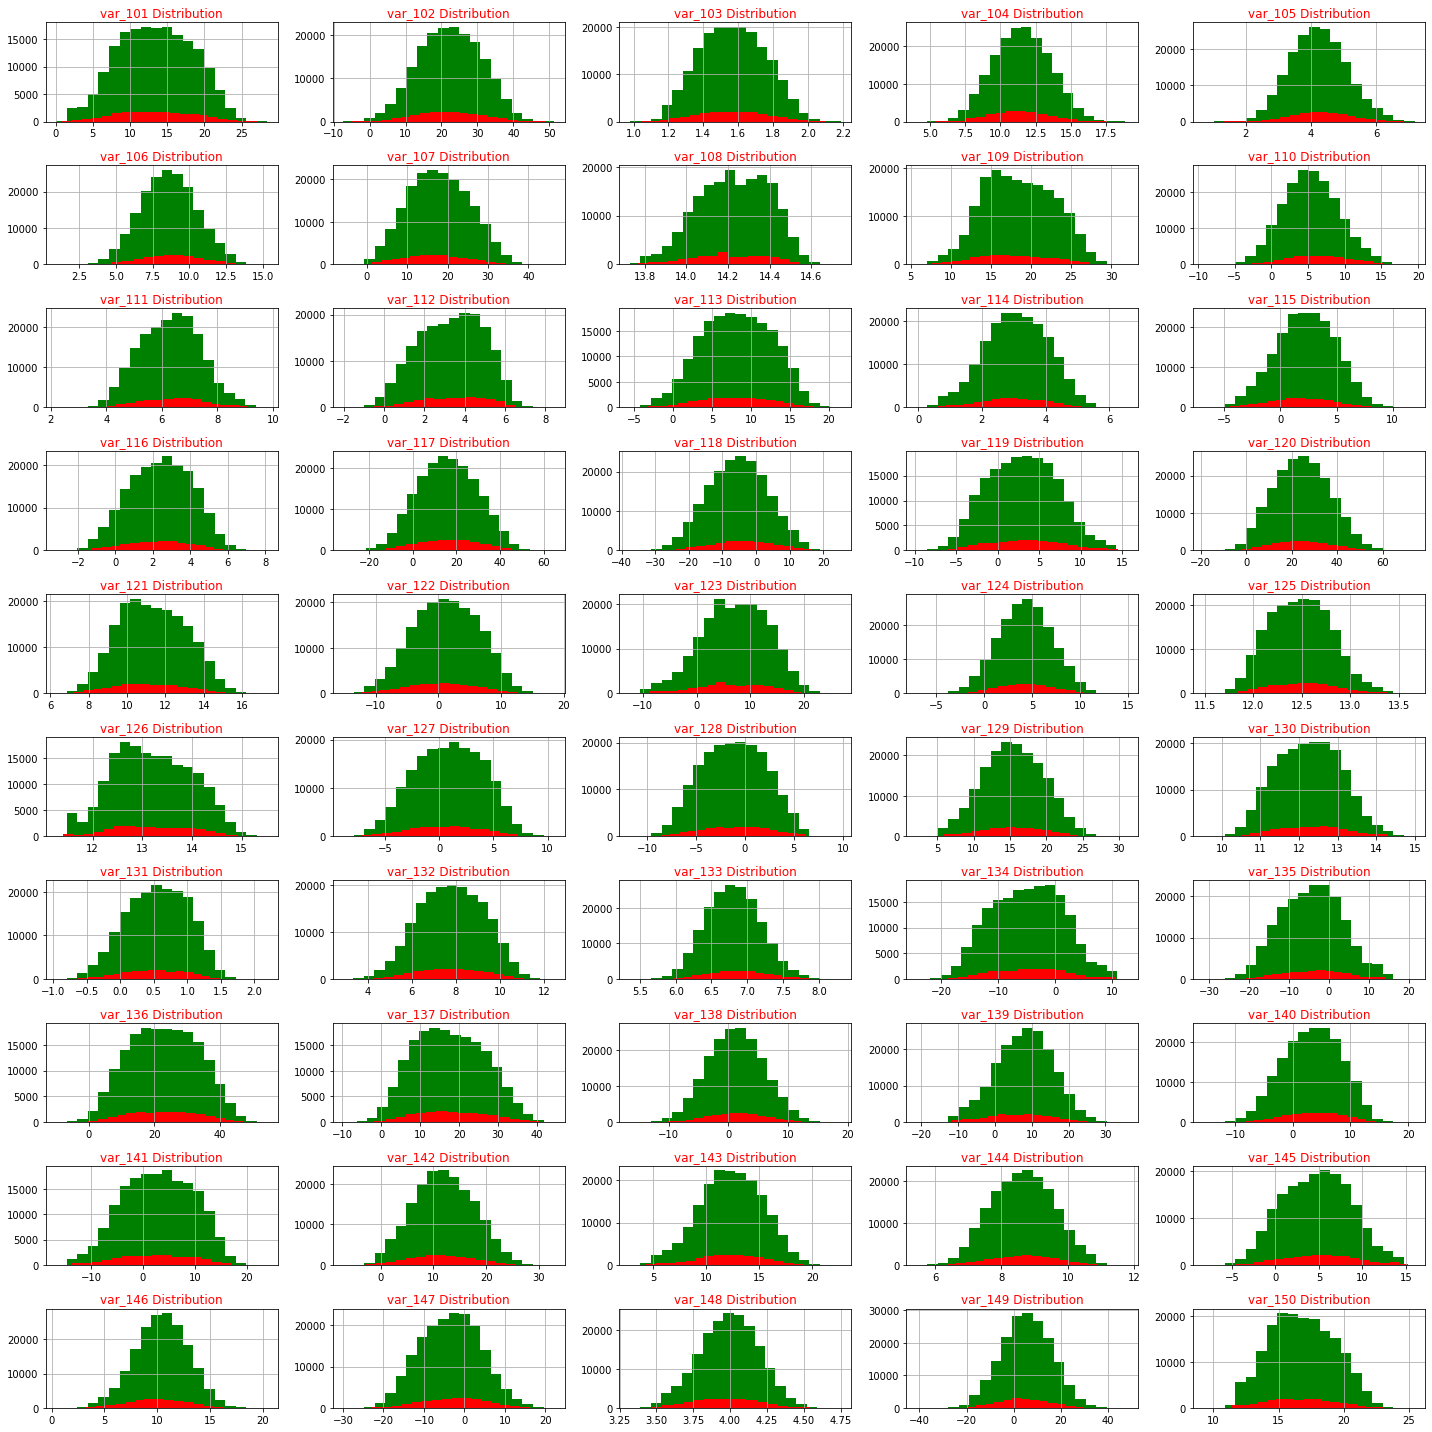

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[101:151])):
    ax=fig.add_subplot(10,5,i+1)
    x_train_0[feature].hist(bins=20,ax=ax,facecolor='green')
    x_train_1[feature].hist(bins=20,ax=ax,facecolor='red')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

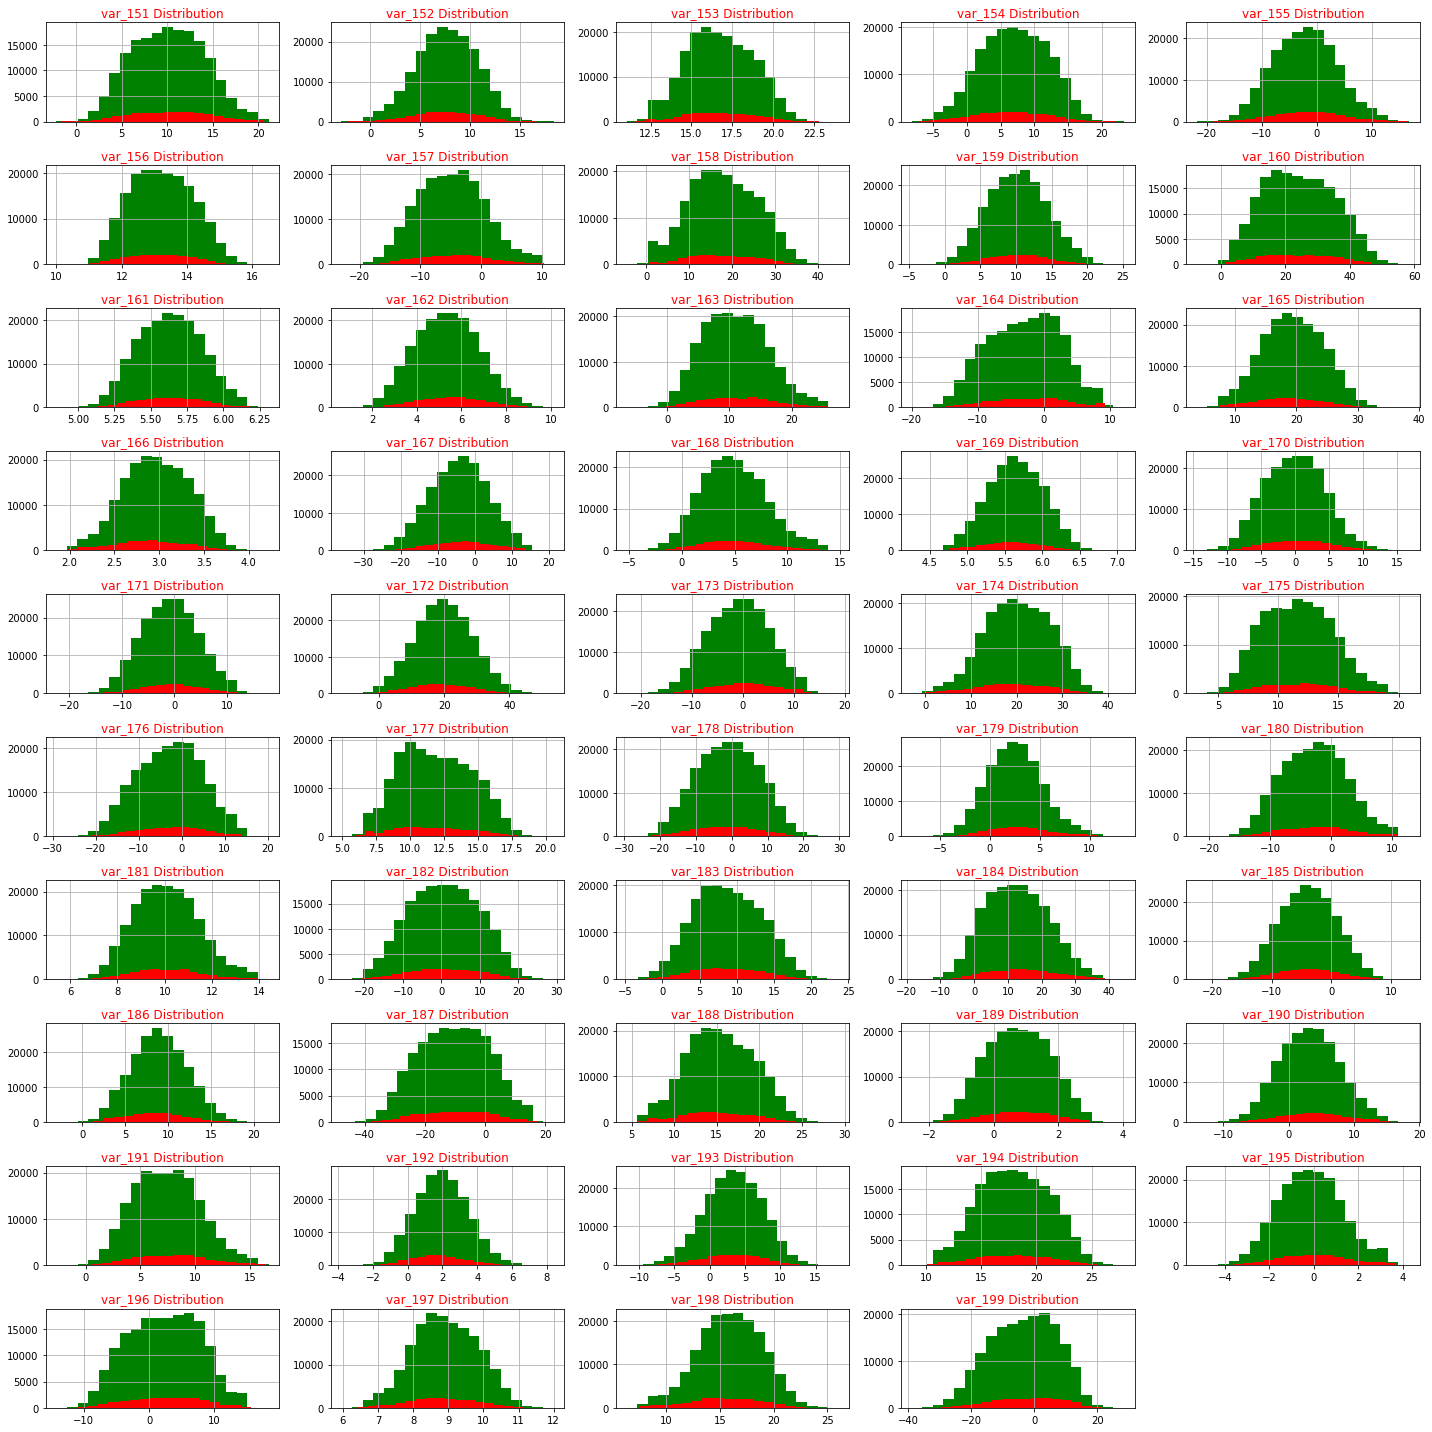

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[151:200])):
    ax=fig.add_subplot(10,5,i+1)
    x_train_0[feature].hist(bins=20,ax=ax,facecolor='green')
    x_train_1[feature].hist(bins=20,ax=ax,facecolor='red')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

Looking at the above plots,
* The distribution of some of these features looks symmetrical. 
* Some features are slightly asymmetric.
* None of the features have heavy-tailed distributions. 
* Overall, they all look like Gaussian distributed features.
* All the features have overlapping distributions for the 2 classes with slight differences.





### Identifying normal distribution

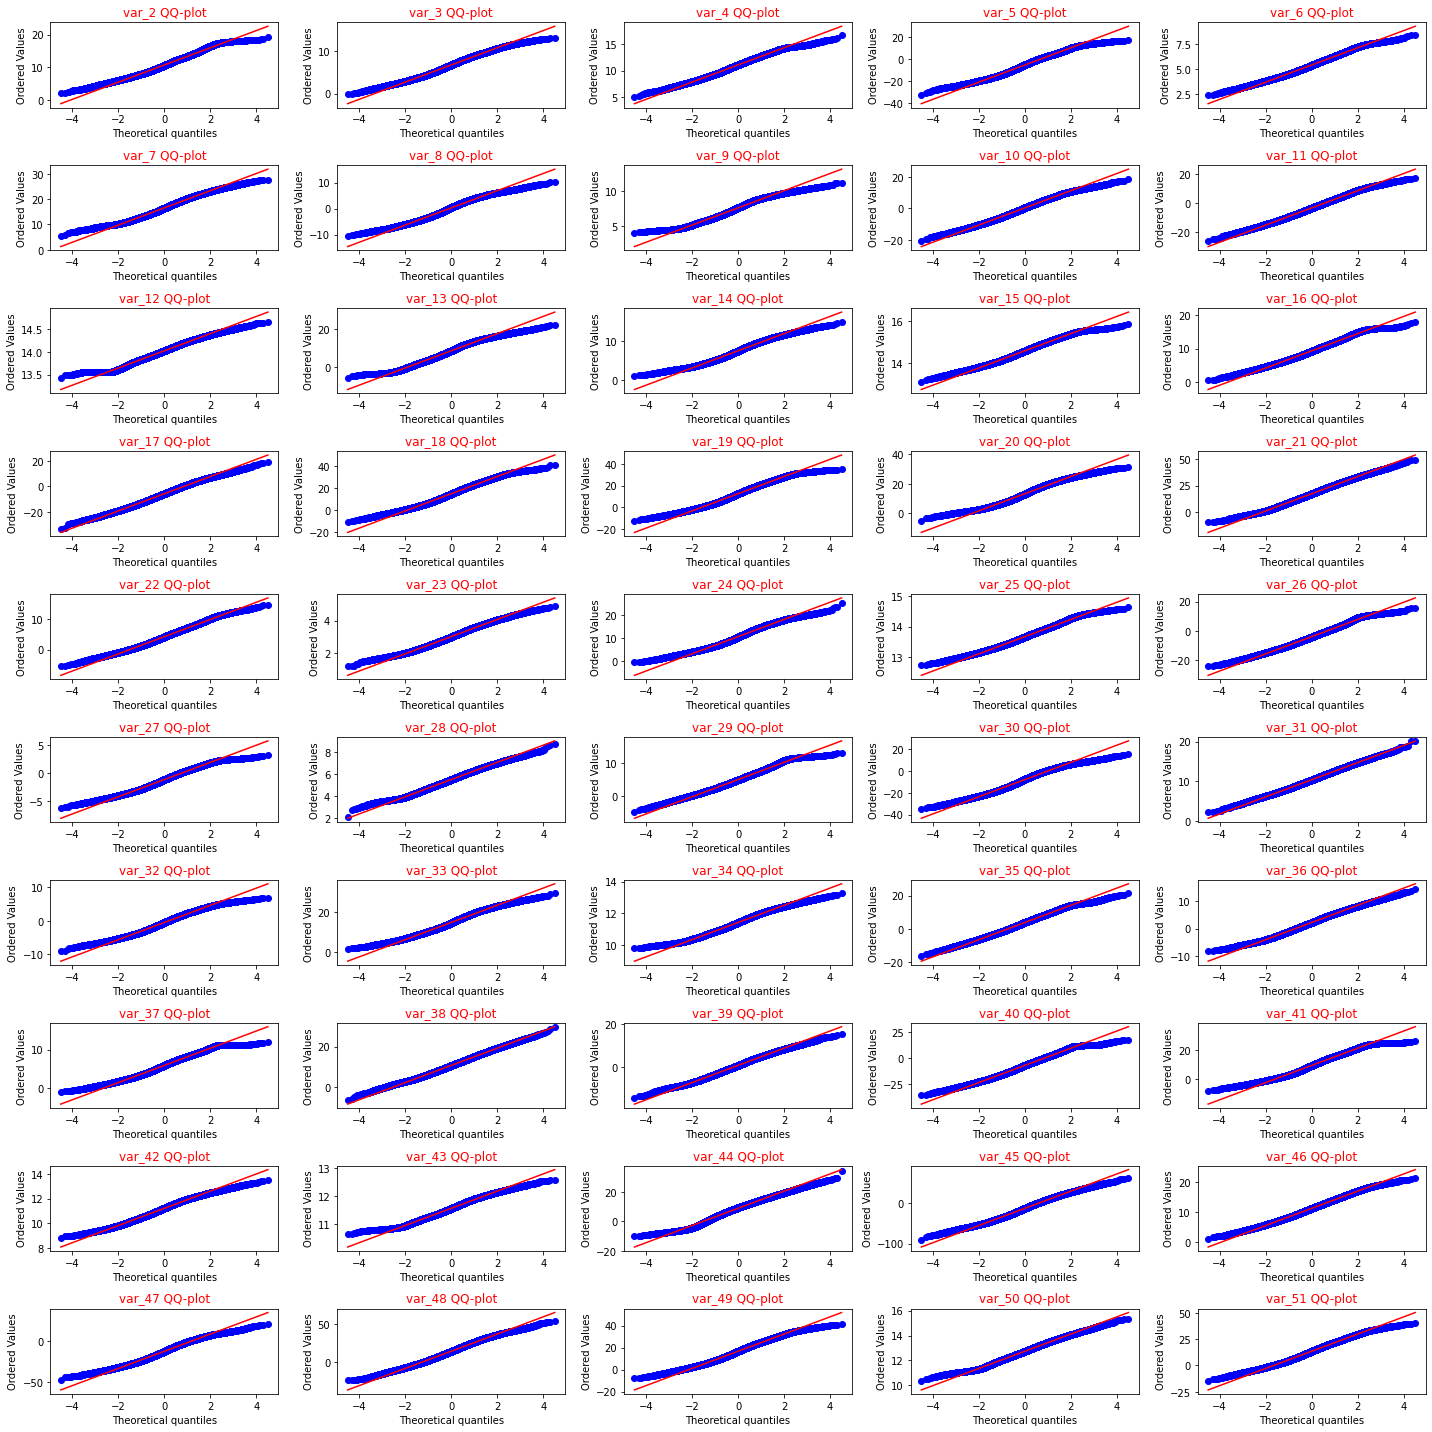

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[2:52])):
    ax=fig.add_subplot(10,5,i+1)
    stats.probplot(train_data[feature], dist="norm", plot=plt)
    ax.set_title(feature+" QQ-plot",color='red')

fig.tight_layout()  
plt.show()

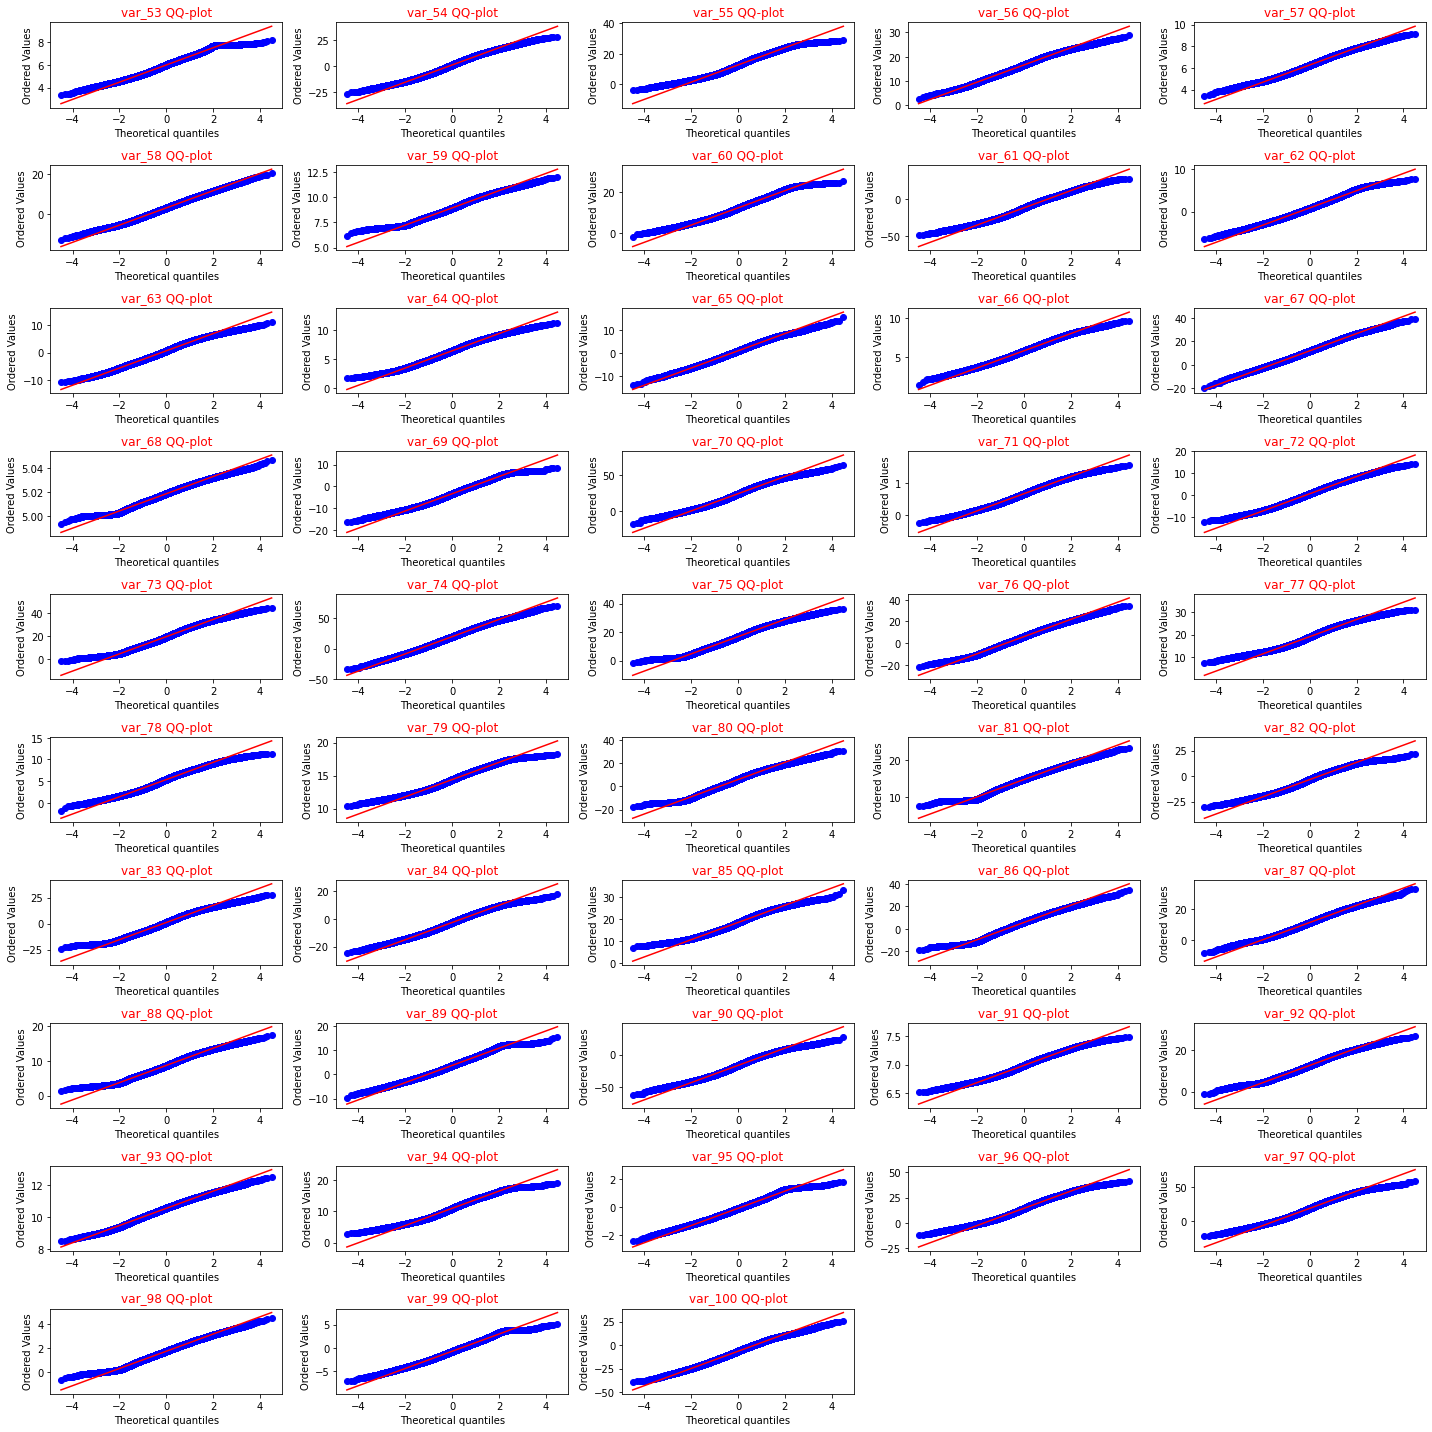

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[53:101])):
    ax=fig.add_subplot(10,5,i+1)
    stats.probplot(train_data[feature], dist="norm", plot=plt)
    ax.set_title(feature+" QQ-plot",color='red')

fig.tight_layout()  
plt.show()

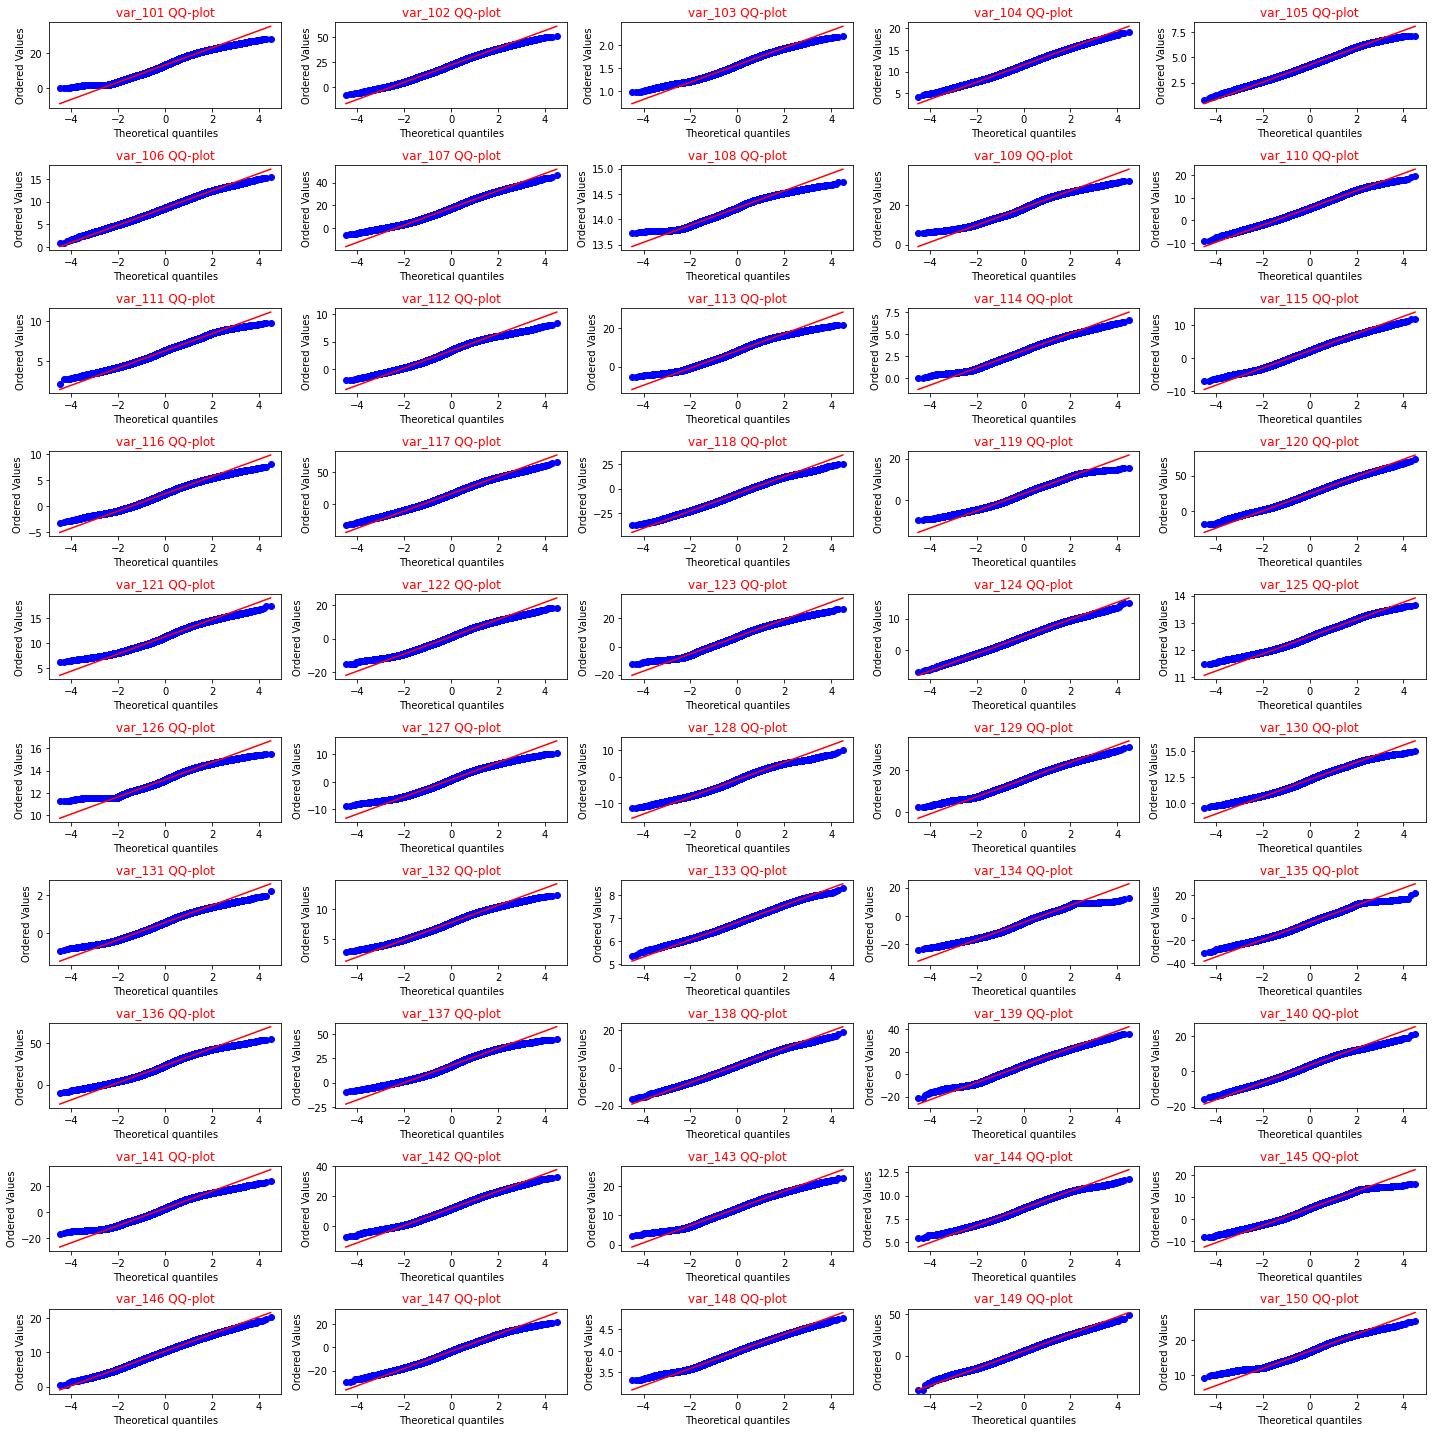

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[101:151])):
    ax=fig.add_subplot(10,5,i+1)
    stats.probplot(train_data[feature], dist="norm", plot=plt)
    ax.set_title(feature+" QQ-plot",color='red')

fig.tight_layout()  
plt.show()

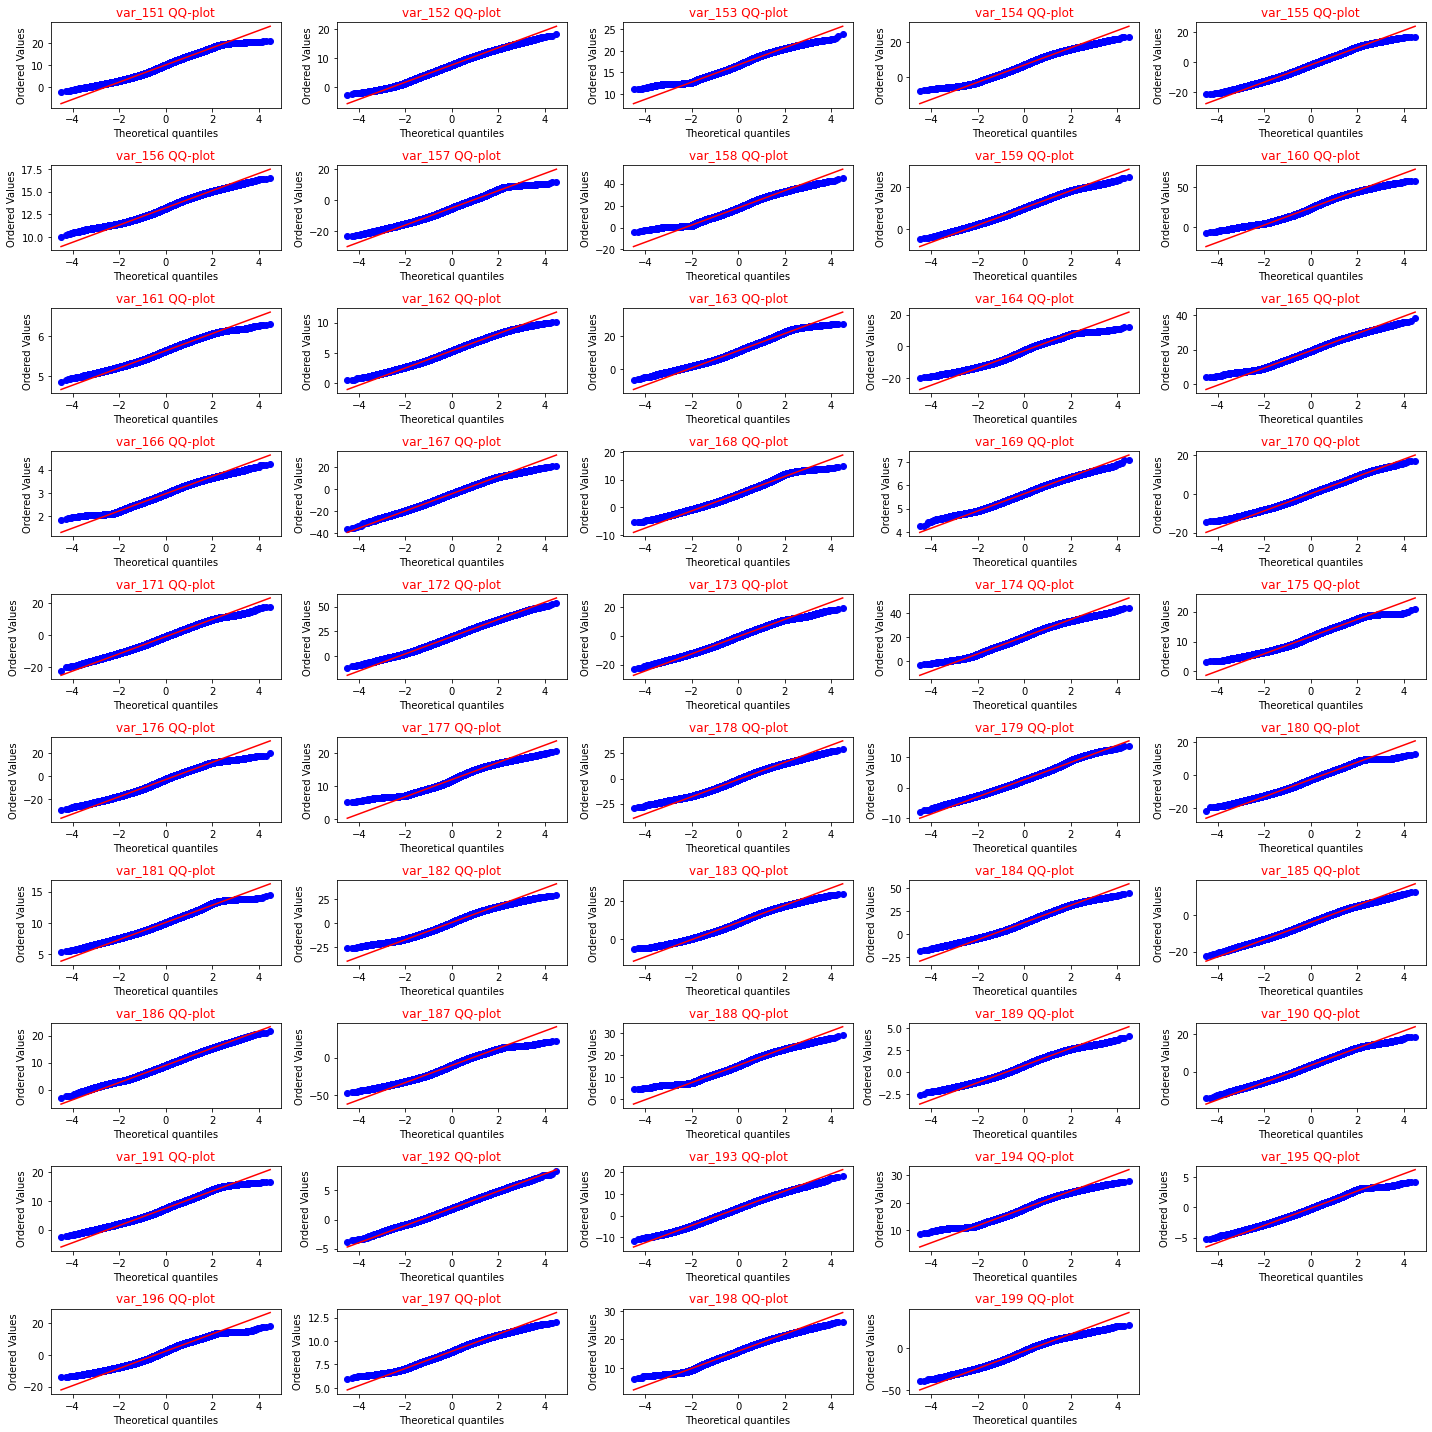

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[151:200])):
    ax=fig.add_subplot(10,5,i+1)
    stats.probplot(train_data[feature], dist="norm", plot=plt)
    ax.set_title(feature+" QQ-plot",color='red')

fig.tight_layout()  
plt.show()

* The variables which are normally distributed, their values follow the theoretical quantiles and thus lie along the 45-degree diagonal.
* Not all of them lie perfectly along the diagonal, there are slight deviations from it.


### Comparing feature magnitude

In [ ]:
x_train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,mean,std,max,min,median,skew,kurt
count,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,...,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000,287818.000000
mean,10.876608,-1.364983,10.907124,6.820340,11.099591,-4.762350,5.485377,16.531512,0.374529,7.497841,...,15.649613,-2.936903,1355.529675,6.777648,9.649336,39.424556,-30.458289,6.687111,-0.172826,2.305498
std,3.154115,4.129602,2.736620,2.055616,1.633352,7.992916,0.897942,3.422575,3.338144,1.258282,...,3.130925,10.463411,81.198070,0.405990,0.570391,5.642051,9.271658,0.407779,0.401688,1.503915
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.749400,-10.505500,4.162400,...,6.299300,-35.256500,992.663500,4.963318,7.369270,22.458300,-90.252500,5.001200,-3.329985,-0.451972
25%,8.544200,-4.526200,8.822400,5.275400,9.890100,-10.963600,4.812200,13.911725,-2.216775,6.547300,...,13.562800,-10.763275,1300.710325,6.503552,9.254261,35.326600,-35.441600,6.413700,-0.410394,1.343962
50%,10.708900,-1.341700,10.794100,6.853200,11.126050,-4.518000,5.476600,16.438000,0.489600,7.570600,...,15.705700,-2.415300,1355.389800,6.776949,9.636120,39.041150,-28.964150,6.700800,-0.141662,1.963253
75%,13.005100,1.637300,12.723400,8.343175,12.291100,1.219950,6.100300,19.075875,3.033175,8.523375,...,17.937350,5.290500,1410.100700,7.050503,10.024926,43.203200,-23.739700,6.959100,0.098210,2.822780
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,26.034600,28.500700,1693.917200,8.469586,12.454861,74.032100,-7.944900,8.673850,1.572738,27.385200


In [ ]:
test_data.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


* There is a **significant difference** between the minimum values of features and maximum values of features.
* The mean and median values are almost the **same**.
* The standard deviation takes values from around **1** to as high as **21**.
* Since there is a significant difference in scales of features, we should do feature scaling as features with bigger values dominate over features with smaller values.
* Having features within a similar scale also helps algorithms converge faster,
improving performance and training times.
* All these values are similar for train and test data, showing they have the **similar distribution**.
* All these are numerical features with just column names. Since the dataset is anonymized, we do not know what their actual meaning is regarding Santander Bank or its customers.

### Distribution of other statistical features

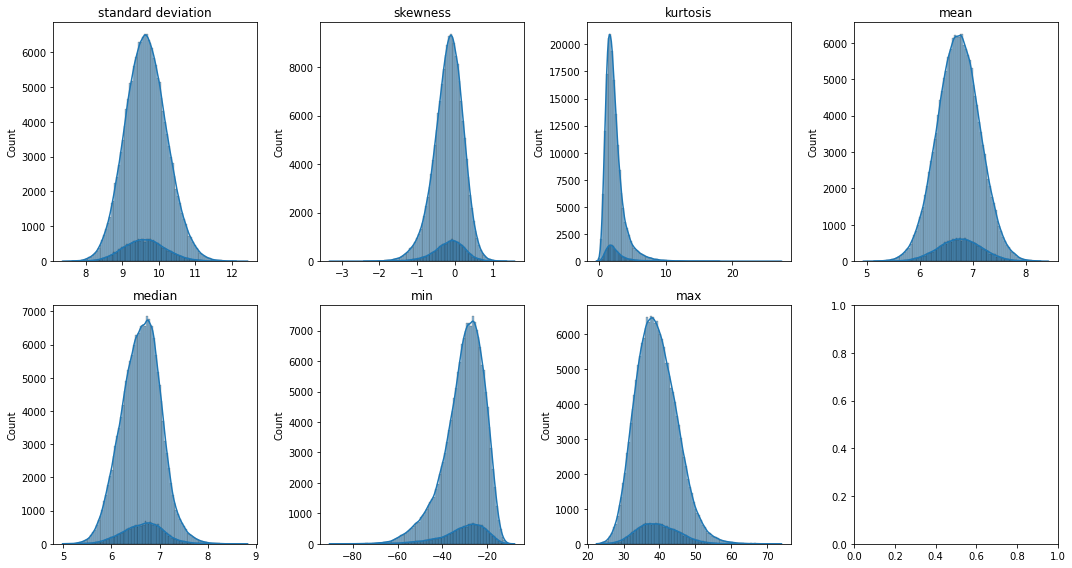

In [ ]:
fig,ax=plt.subplots(2, 4, figsize=(15, 8))
sns.histplot(x_train_0.std(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,0])
sns.histplot(x_train_1.std(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,0])
ax[0,0].set_title('standard deviation')

sns.histplot(x_train_0.skew(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,1])
sns.histplot(x_train_1.skew(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,1])
ax[0,1].set_title('skewness')

sns.histplot(x_train_0.kurtosis(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,2])
sns.histplot(x_train_1.kurtosis(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,2])
ax[0,2].set_title('kurtosis')

sns.histplot(x_train_0.mean(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,3])
sns.histplot(x_train_1.mean(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[0,3])
ax[0,3].set_title('mean')

sns.histplot(x_train_0.median(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,0])
sns.histplot(x_train_1.median(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,0])
ax[1,0].set_title('median')

sns.histplot(x_train_0.min(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,1])
sns.histplot(x_train_1.min(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,1])
ax[1,1].set_title('min')

sns.histplot(x_train_0.max(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,2])
sns.histplot(x_train_1.max(axis=1,numeric_only=True), kde=True, bins=100,ax=ax[1,2])
ax[1,2].set_title('max')

fig.tight_layout()  
plt.show()

* All the above features have **overlapping distributions** for the 2 classes, individually they add little value.  
* The PDF of kurtosis plots is right skewed.
* The PDF of skew is slightly left skewed.
* The rest of the PDFs are not that skewed, they look like symmetric distribution.

## Outliers

### Boxplots

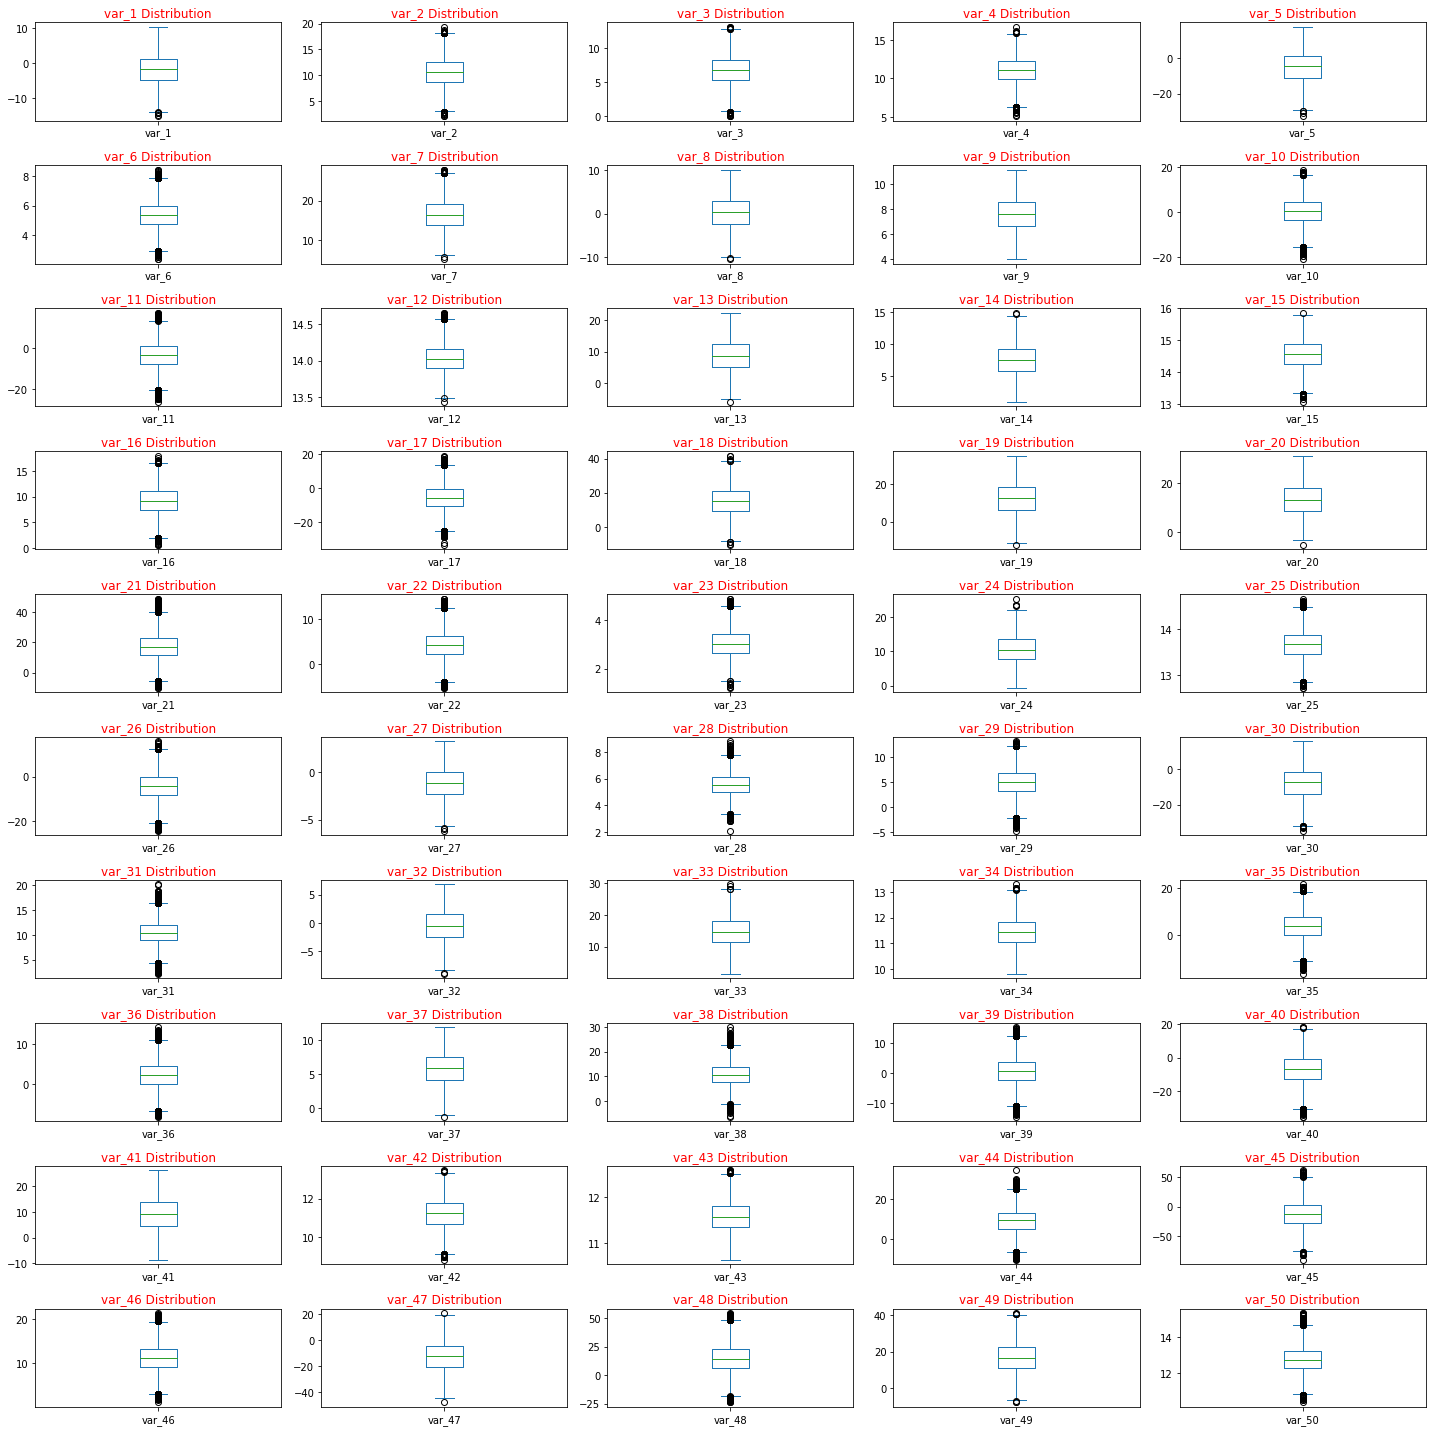

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[2:52])):
    ax=fig.add_subplot(10,5,i+1)
    x_train[feature].plot.box()
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

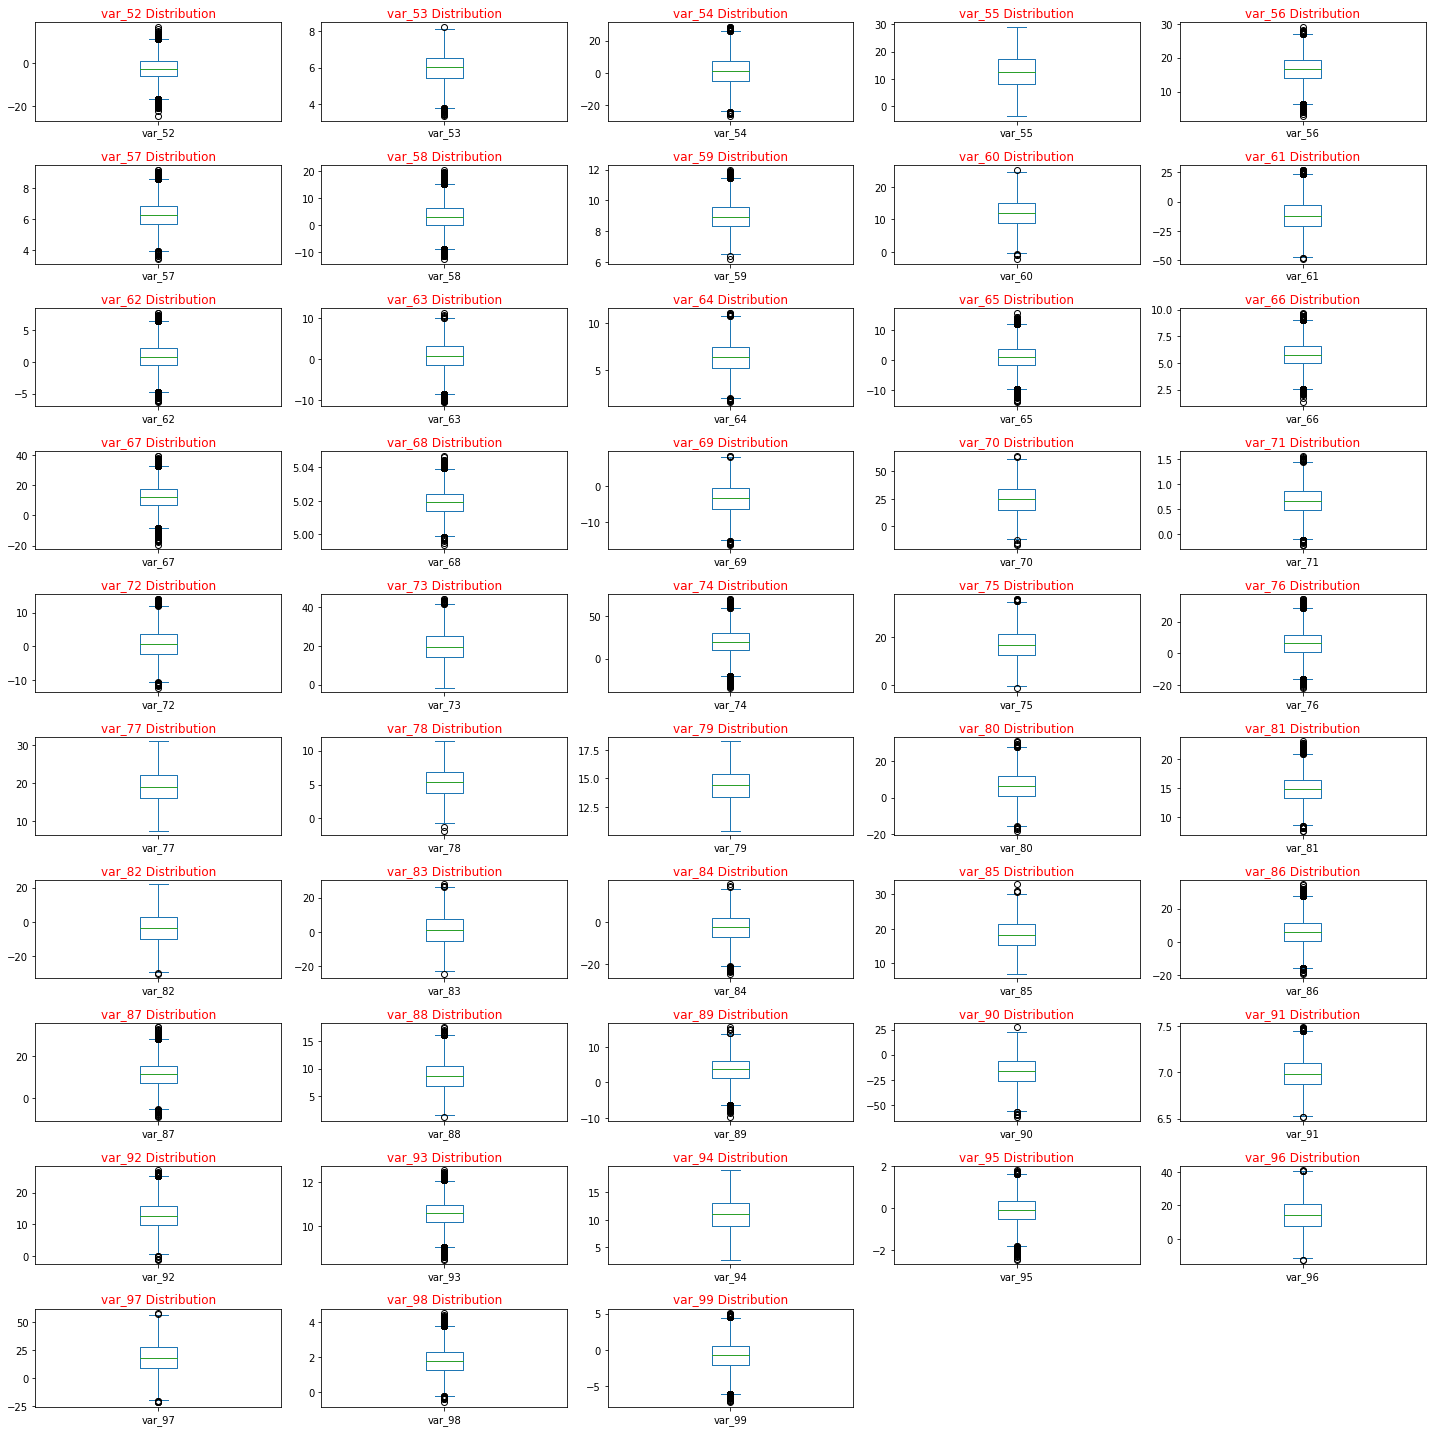

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[53:101])):
    ax=fig.add_subplot(10,5,i+1)
    x_train[feature].plot.box()
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

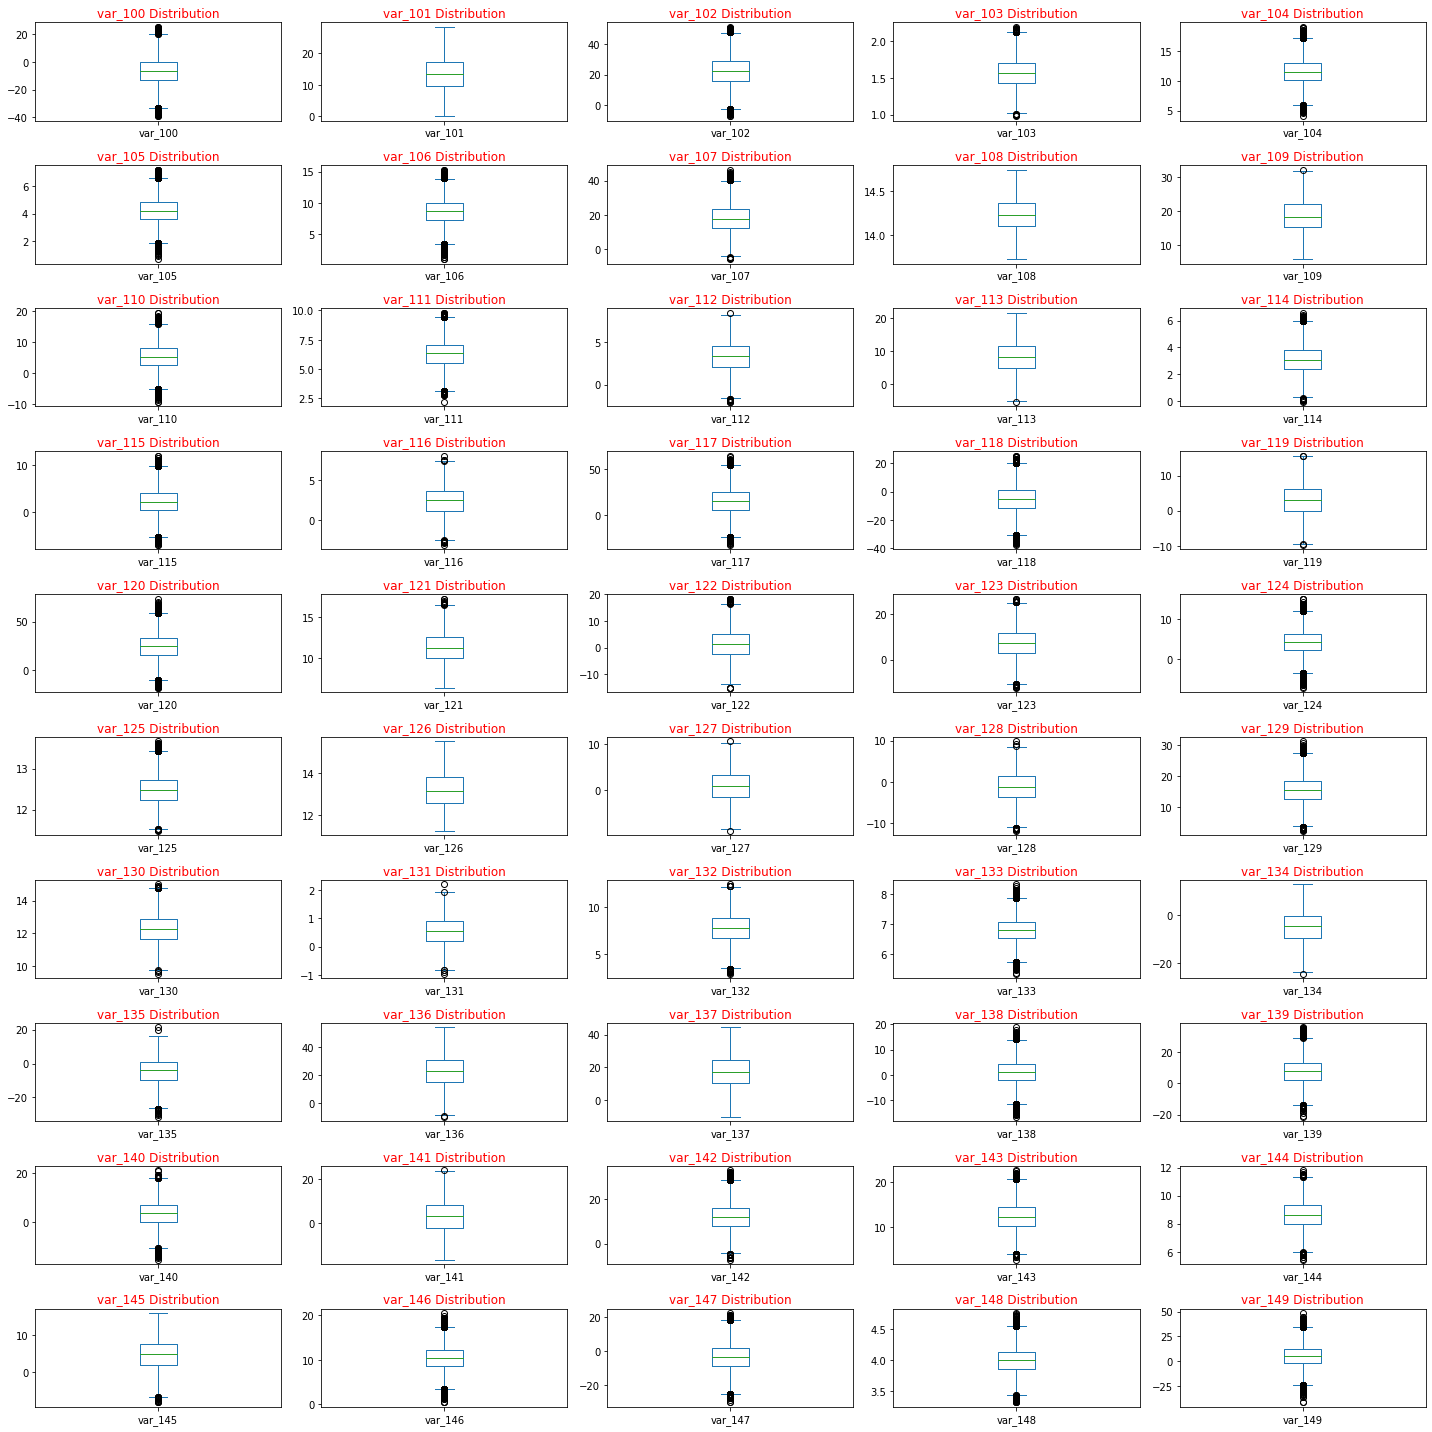

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[101:151])):
    ax=fig.add_subplot(10,5,i+1)
    x_train[feature].plot.box()
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

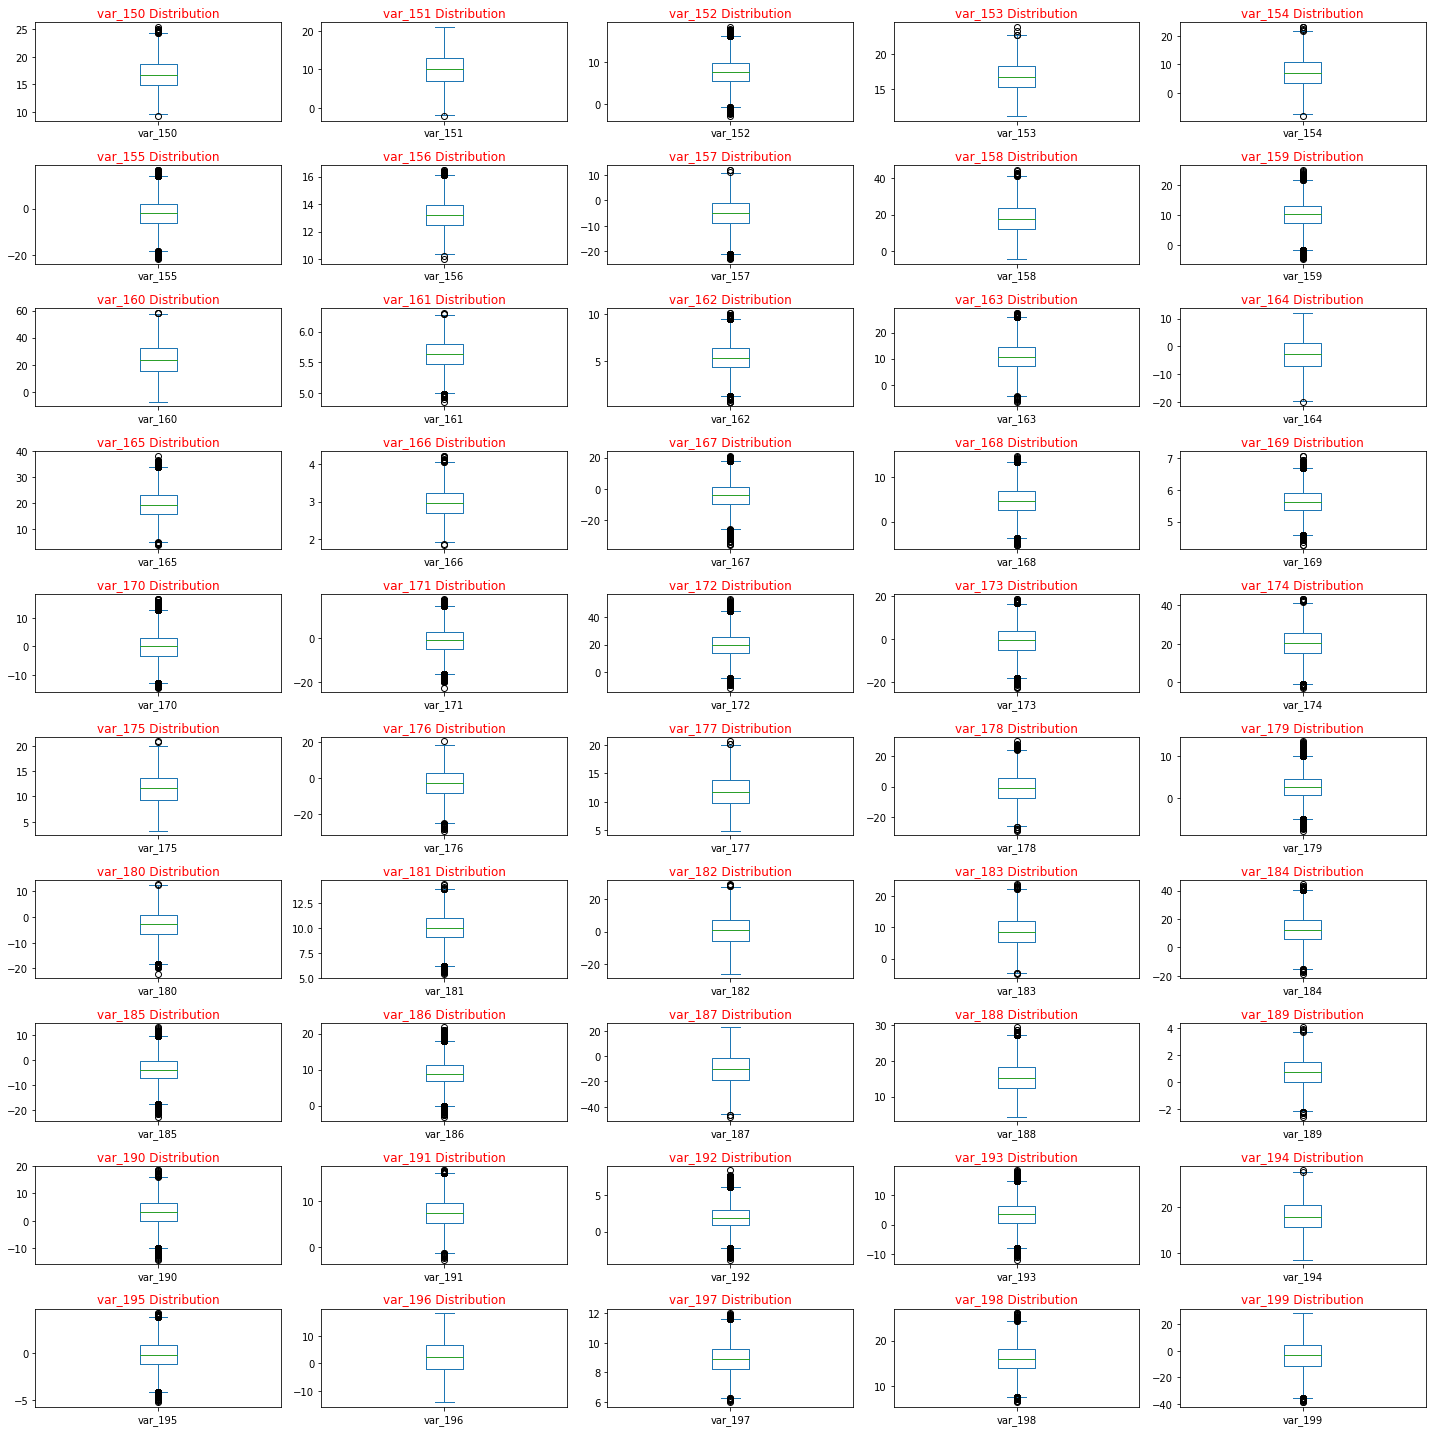

In [ ]:
fig=plt.figure(figsize=(20,20))
for i, feature in enumerate(list(x_train.columns[151:])):
    ax=fig.add_subplot(10,5,i+1)
    x_train[feature].plot.box()
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()  
plt.show()

Based on the above box plots,
* Columns with no outliers - var_9, 55, 77, 79, 94, 101, 108, 156, 137, 196
* Columns with fewer outliers - var_8, 13, 14, 19, 20, 32, 37, 78, 113, 119, 134, 136, 151, 160, 164, 175
* The rest of the columns have a significant amount of outliers.


### Removing outliers

ref: https://www.codegrepper.com/code-examples/python/how+to+remove+outliers+from+data+in+python+using+box+plot


In [ ]:
def remove_outlier(df_in, col_name):
  """ This function removes rows containing outliers from the dataframe 
  based on it's position above or below whiskers of box plots"""
  
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  iqr = q3-q1 
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  return df_out

In [ ]:
x_train_clean = pd.DataFrame()
for feature in list(x_train.columns[2:]):
  x_train_clean = remove_outlier(train_data,feature)

In [ ]:
print(f"The percentage of outliers is {((len(train_data) - len(x_train_clean))/len(train_data)) * 100} ")

The percentage of outliers is 0.01 


In [ ]:
#Separating the target column from the rest of the data.
x_clean = x_train_clean.drop(['target'],axis=1)
y_clean = x_train_clean.target.astype(int)

https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.box.html
* I have considered the points above and below the whiskers as outliers. 
* I calculated the position of whiskers as '75th quantile + (IQR * 1.5)' and '25th quantile - (IQR * 1.5)', (IQR - interquartile range) according to the pandas' documentation above.
* I deleted the outliers' row from the data frame.
* There are other ways to detect and remove outliers, like from Z-score or scatter plots or local outlier factor. But the outliers were clearly visible with the help of box plots, so I chose this method.


## Relationship between variables

In [ ]:
corr = train_data.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

* From above plot, if we observe all the values, the correlation between variables is very small. 





In [ ]:
top = corr.unstack().abs()
top_values = top.sort_values(kind="quicksort")

#removing correlation values with itself
ind = [i for i in range(40200,40401)]
top_values = top_values.drop(top_values.index[ind])

In [ ]:
#to avoid looking at redundant pairs of features
top_corr = dict()
for i in top_values.tail(40).items():
  top_corr[i[1]] = i[0] 

low_corr = dict()
for i in top_values.head(40).items():
  low_corr[i[1]] = i[0] 

**Top 20 correlated features**

In [ ]:
top_corr

**The least 20 correlated features**

In [ ]:
low_corr

* The correlation between features and regarding target variable is very less.
* Within that, the highest and lowest correlation of features is listed above.
* Since there is no strong correlation between variables or with target variables, it is better to treat all features are equal and drop none of them, based on this.

## Conclusion

* It seems like they have given well processed anonymized dataset with 200 numeric features, 1 target column, and an ID_column. 
* All these numeric variables are continuous numeric variables.
* The data is clean, with no missing values or duplicate entries. 
* There are around 0.01% outliers that were removed.
* There is no correlation between features.
* The dataset is imbalanced with 10% data belonging to class 1
* There are only slight differences in the distributions of these features regarding their class labels. It's the same case with mean, median, skewness, kurtosis, and standard deviation. They have overlapping distributions.
* From the QQ-plots, we can say most of the features among the 200 numeric features follow the normal distribution.
* We need to come up with better features that will be more discriminative of the two classes or using all the features together could give excellent results.
* Since the correlation between all features and with respect to target variable is small, we cannot eliminate any of the features, the features do not have any redundant information.


# Splitting the data and data augumentation

In [ ]:
x_tr, x_c, y_tr, y_c = train_test_split(x_clean, y_clean, test_size = 0.30, stratify = y_clean)

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_train, y_train = oversample.fit_resample(x_tr, y_tr)
x_cv, y_cv = oversample.fit_resample(x_c, y_c)

* Stratified splitting ensures it splits the dataset proportionally into train and cv sets according to class labels.
* Since the dataset is highly imbalanced, we can perform either up-sampling or down-sampling to make it balanced. But down-sampling removes information, so I chose the up-sampling technique. Here, only minority class points are resampled.


In [ ]:
train_id_codes = x_train['ID_code']
cv_id_codes = x_cv['ID_code']
test_id_codes = test_data['ID_code']

In [ ]:
x_train.drop('ID_code',axis=1,inplace=True)
x_cv.drop('ID_code',axis=1,inplace=True)
test_data.drop('ID_code',axis=1,inplace=True)

# Feature Engineering

## Statistical features

In [ ]:
def cal_stats(dataframe):
  """calculates statistical features along axis 1 and 
  returns a dataframe with the new features added"""

  features = dataframe.columns.values[:]
  dataframe['sum'] = dataframe[features].sum(axis=1)  
  dataframe['mean'] = dataframe[features].mean(axis=1)
  dataframe['std'] = dataframe[features].std(axis=1)
  dataframe['max'] = dataframe[features].max(axis=1)
  dataframe['min'] = dataframe[features].min(axis=1)
  dataframe['median'] = dataframe[features].median(axis=1)
  dataframe['skew'] = dataframe[features].skew(axis=1)
  dataframe['kurt'] = dataframe[features].kurtosis(axis=1)

  return dataframe

In [ ]:
x_train = cal_stats(x_train)

In [ ]:
x_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,mean,std,max,min,median,skew,kurt
0,10.2487,-4.9694,9.6390,8.9432,8.9995,-12.2882,4.9203,13.7659,2.1582,6.7733,...,13.0430,-7.2800,1433.5872,7.167936,9.812115,38.9000,-27.9099,7.16605,0.046069,1.562099
1,8.4040,0.8872,13.4467,3.5029,13.3157,-16.2556,7.3771,19.2522,-3.4627,6.8990,...,14.7073,-19.3792,1452.5409,7.262705,9.449009,41.6035,-22.5010,7.25930,-0.021996,2.128585
2,13.7307,2.3845,11.9953,5.2486,9.7716,-5.1318,5.8402,19.3078,2.1918,6.7436,...,14.6366,13.1844,1368.4682,6.842341,9.439798,34.7979,-32.2589,6.41710,-0.543259,2.507485
3,10.2656,-5.5287,10.0789,8.6231,12.9828,-6.4445,4.1116,12.3685,1.8477,8.8852,...,16.2594,-11.1590,1244.6146,6.223073,9.657531,43.1739,-26.5672,6.51765,-0.210353,2.139348
4,14.7176,-5.2689,11.9639,3.3445,12.3037,-8.8625,5.9532,18.7069,-2.7486,5.8750,...,16.2314,1.7564,1373.1993,6.865996,10.011614,34.1126,-30.0081,7.15350,-0.407240,1.473133


In [ ]:
x_cv = cal_stats(x_cv)

In [ ]:
x_cv.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,mean,std,max,min,median,skew,kurt
0,6.9119,4.0098,7.9379,9.8497,10.1008,-10.0019,6.9378,23.3573,5.4205,6.3423,...,21.9377,-16.1081,1340.7531,6.703765,9.967595,35.7813,-28.6300,6.93290,-0.320957,0.805293
1,7.4537,2.9040,10.1230,8.5480,12.3171,-13.4403,4.6634,21.8811,-1.9403,5.7805,...,17.9042,10.7579,1294.7740,6.473870,9.392826,40.9722,-20.3388,6.17470,0.279670,1.680882
2,13.0262,0.8985,16.5743,5.8218,8.3827,-10.3261,7.1507,17.1775,0.9969,7.1515,...,15.5590,-15.1664,1270.1526,6.350763,10.920168,47.0277,-57.3617,6.62770,-1.051567,6.391278
3,14.3204,-1.9759,8.4745,5.9204,12.5325,3.8383,5.5324,11.8750,0.9150,6.3343,...,13.3706,-20.4866,1339.5345,6.697672,10.919538,43.1661,-38.0639,6.28305,-0.376255,2.525279
4,13.2509,1.8552,11.5913,8.6950,13.7852,7.7153,5.1412,17.7612,3.7729,8.0433,...,18.8429,-11.7621,1377.0266,6.885133,9.151646,35.1355,-29.0182,7.02215,-0.412981,1.751314


In [ ]:
test_data = cal_stats(test_data)

## Yeo-Johnson Transform

In [ ]:
def transform(data):
  """ this function performs Yeo-Johnson transformation on the data """
  
  pt = PowerTransformer(method='yeo-johnson')
  x = pt.fit_transform(data)
  x = pd.DataFrame(x)
  x.columns = x.columns.astype(str)
  return x

In [ ]:
gaussian_train = transform(x_train)

In [ ]:
gaussian_train.head()

In [ ]:
gaussian_cv = transform(x_cv)

In [ ]:
gaussian_cv.head()

*  We saw in EDA, that our data has Gaussian-like distribution.
* To make data more like Gaussian, we apply the Yeo-Johnson transformation on each set separately.
* The Yeo-Johnson transform does not require the values for each input variable to be strictly positive. It supports zero values and negative values.
* We get better performance with Gaussian distributed data, especially with machine learning algorithms like logistic regression.

In [ ]:
gaussian_test = transform(test_data)

# Model Implementations

In [ ]:
def training(model, label):
  """ this function trains the passed model with training 
  and validation data and returns ROC-AUC score"""

  model.fit(gaussian_train, y_train)
  y_pred = model.predict_proba(gaussian_cv)
  y_pred = y_pred[:, 1]
  auc = roc_auc_score(y_cv, y_pred)
  print(label + f": ROC AUC = {auc}")
  fpr, tpr, _ = roc_curve(y_cv, y_pred)
  plt.plot(fpr, tpr, marker='.', label=label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

## Logistic Regression

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 1.0, 0.1, 0.01]
param = dict(solver=solvers,penalty=penalty,C=c_values)

model = LogisticRegression()
random_search = RandomizedSearchCV(model, param, cv=5, scoring='roc_auc', return_train_score=True)
rand_result = random_search.fit(gaussian_train, y_train)

print("best parameters = ",rand_result.best_params_)

best parameters =  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}


Logistic Regression: ROC AUC = 0.8652549393979786


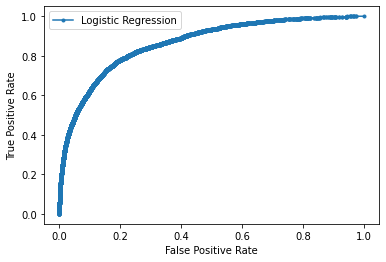

In [ ]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C= 10)
training(model, label='Logistic Regression')

## Gaussian Naive Bayes

In [ ]:
model = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=200)}

random_search = RandomizedSearchCV(model, param, cv=5, scoring='roc_auc', return_train_score=True)
rand_result = random_search.fit(gaussian_train, y_train)
print("best parameters = ", rand_result.best_params_)

best parameters =  {'var_smoothing': 5.291978735958436e-09}


Gaussian Naive Bayes: ROC AUC = 0.8822975022595395


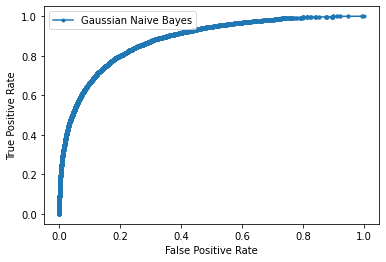

In [ ]:
model = GaussianNB(var_smoothing = 5.291978735958436e-09)
training(model,'Gaussian Naive Bayes')

## Random Forest

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

clf = RandomForestClassifier(random_state=0)
param_grid = {'n_estimators': [200, 300, 400], 
              'max_depth': [5, 10, 15], 
              'criterion': ['gini', 'entropy']}
search = HalvingGridSearchCV(clf, param_grid, scoring='roc_auc', min_resources='exhaust', factor=3, random_state=0).fit(x_cv, y_cv)
search.best_params_  

best parameters =  {'n_estimators': 400, 'max_depth': 15, 'criterion': 'entropy'}


Random Forest: ROC AUC = 0.8123951014004133


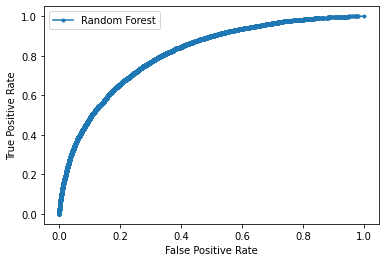

In [ ]:
model = RandomForestClassifier(n_estimators=400, max_depth=15, criterion='entropy')
training(model,'Random Forest')

## Conclusion

* The dataset above comprises the Gaussian transformed dataset on 200 numerical features given by Santander bank and statistical features I calculated.
* Training the models only on these features gives the result:
  1. Logistic Regression: AUC - 0.865
  2. Random Forest: AUC - 0.812
  3. Naive Bayes: AUC - .882
* Naive Bayes gives the best result among the 3 models. 
* Random Forest model takes more time to train compared to the other two models.

## LightGBM with Frequency Encoding

ref: https://github.com/btrotta/kaggle-santander-2019/blob/master/Readme.pdf

In [ ]:
def check_unique(dataframe):
  """prints if a value in a column is unique or not"""

  col_names = dataframe.columns[:200]
  unique = []
  for col in col_names:
    unique.append(dataframe[col].is_unique)
  print(unique)

In [ ]:
check_unique(gaussian_train)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
check_unique(gaussian_cv)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
check_unique(test_data)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

* In EDA, we saw there were no duplicate entries or rows. But inspecting the data reveals that there are duplicate values within each column in both training and test datasets in all columns.
* We check this with is_unique method of pandas, which returns True only if there are no duplicate values within the column.
* We can use this information to create new features and improve the performance of the model.


In [ ]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

col_names = train_data.columns[2:200]
freq_train = {}
for col in col_names:
  freq_train[col] = train_data[col].value_counts()

col_names = test_data.columns[2:200]
freq_test = {}
for col in col_names:
  freq_test[col] = test_data[col].value_counts()

In [ ]:
#https://www.kaggle.com/code/philippsinger/frequency-features-without-test-data-information
test_preditions = 0
parameters = {'learning_rate':0.05, 'max_bin': 165, 'max_depth': 5, 'min_child_samples': 150,
        'min_child_weight': 0.1, 'min_split_gain': 0.0018, 'n_estimators': 41, 'metric':'auc',
        'num_leaves': 6, 'reg_alpha': 2.0, 'reg_lambda': 2.54, 'objective': 'binary', 'n_jobs': -1}

for column in col_names:
  classifier = lgbm.LGBMClassifier(**parameters)
  classifier.fit(np.hstack([train_data[column].values.reshape(-1,1), train_data[column].map(freq_train[column]).values.reshape(-1,1)]),
                   train_data["target"].values)
  x_test = np.hstack([test_data[column].values.reshape(-1,1), test_data[column].map(freq_test[column]).values.reshape(-1,1)])
  x_test[:,1] = x_test[:,1] + 1
  x_test[:,1][np.isnan(x_test[:,1])] = 1
  test_preditions =  test_preditions + logit(classifier.predict_proba(x_test)[:,1])

In [ ]:
pd.DataFrame({'ID_code': test_data['ID_code'], 'target': test_preditions}).to_csv('final_submission.csv', index=False)

### Conclusion

ref: https://github.com/btrotta/kaggle-santander-2019/blob/master/Readme.pdf

* The key to feature engineering here was to use the information, number of times a value occurs within each column in the training data.
* Every column, along with it's frequency counts was used to train the model and get prediction probabilities. So model was trained column wise.
* All the prediction probabilities are summed up to get final predictions.
* By Bayes's theorm we know class probabilities are calculated as follows:
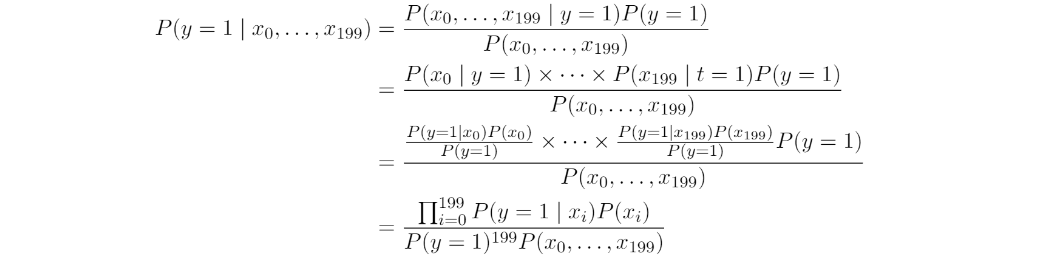

* Instead, if we take logit of probabilities i.e., log(p/1-p), we can avoid these tedious calculations as shown below:
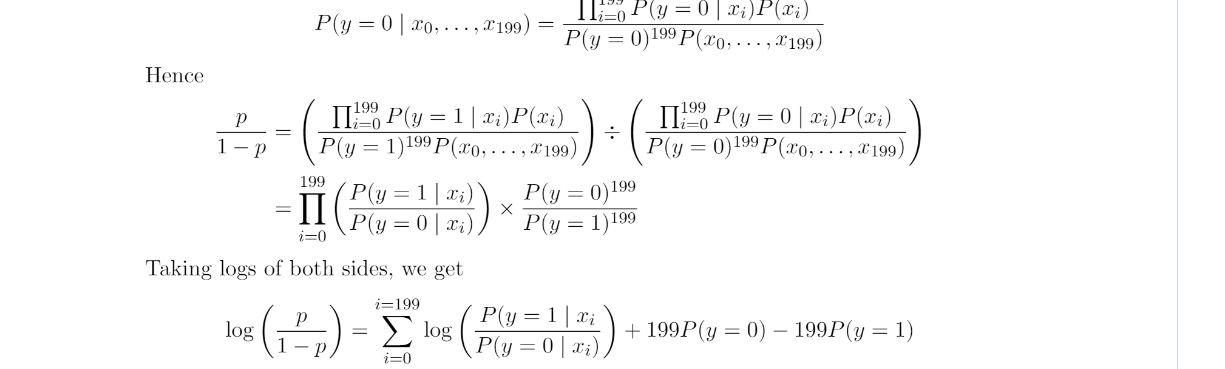

* In this approach, I was able to get an AUC of 0.91 on test dataset.